In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [2]:
layers = [2, 20, 3]
network = NeuralNet(layers=layers, quadraticForm=True, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0., 'data':1, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

pointCount = 100
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-1, 1e-2, 1e-3]
iterations = [1000, 2000, 4000]

In [3]:
# we can develop our own optimiser (like what i did during the master thesis)
# in the general case its almost impossible to project into the space of positive definite solution
# but in the case of the parameters being the matrix, we can easily project? 
# check on google if there is a way to get the nearest positive definite matrix from an existing matrix?
# this also depends on the norm we choose for the projection
# https://math.stackexchange.com/questions/2776803/matrix-projection-onto-positive-semi-definite-cone-with-respect-to-the-spectral
# https://stat.ethz.ch/R-manual/R-devel/library/Matrix/html/nearPD.html
# https://stackoverflow.com/questions/10939213/how-can-i-calculate-the-nearest-positive-semi-definite-matrix
# https://www.statsmodels.org/dev/generated/statsmodels.stats.correlation_tools.cov_nearest.html

In [4]:
from statsmodels.stats.correlation_tools import cov_nearest

In [12]:
# or there is this straightforward solution
import numpy as np

def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

def is_pos_semidef(x):
    return np.all(np.linalg.eigvals(x) >= 0)

In [22]:
A = np.array([[1., 2.], [1., -2.]])

In [24]:
B = get_near_psd(A)
B

array([[1.38388348, 0.5732233 ],
       [0.5732233 , 0.23743687]])

In [26]:
is_pos_semidef(A)

False

In [45]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)
yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        xInt = generateData.samplePoints(pointCount)
        
        # residual
        gradInt = network.computeValueFunctionDerivative(xInt)
        equation = lqr.computeHamiltonJacobiEquation(xInt, gradInt)
        loss = torch.mean( equation**2 )

        # data
        #yData = network.computeValueFunction(xData)
        #loss = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

0 / 7000 (0 / 1000), lr:1.0e-01, loss:9.38e-01
100 / 7000 (100 / 1000), lr:1.0e-01, loss:5.92e-03
200 / 7000 (200 / 1000), lr:1.0e-01, loss:4.35e-03
300 / 7000 (300 / 1000), lr:1.0e-01, loss:3.67e-03
400 / 7000 (400 / 1000), lr:1.0e-01, loss:4.24e-03
500 / 7000 (500 / 1000), lr:1.0e-01, loss:3.47e-03
600 / 7000 (600 / 1000), lr:1.0e-01, loss:2.67e-03
700 / 7000 (700 / 1000), lr:1.0e-01, loss:2.53e-03
800 / 7000 (800 / 1000), lr:1.0e-01, loss:2.56e-03
900 / 7000 (900 / 1000), lr:1.0e-01, loss:1.74e-03
1000 / 7000 (0 / 2000), lr:1.0e-02, loss:1.41e-03
1100 / 7000 (100 / 2000), lr:1.0e-02, loss:1.30e-03
1200 / 7000 (200 / 2000), lr:1.0e-02, loss:6.98e-04
1300 / 7000 (300 / 2000), lr:1.0e-02, loss:3.81e-04
1400 / 7000 (400 / 2000), lr:1.0e-02, loss:3.98e-04
1500 / 7000 (500 / 2000), lr:1.0e-02, loss:2.57e-04
1600 / 7000 (600 / 2000), lr:1.0e-02, loss:1.49e-04
1700 / 7000 (700 / 2000), lr:1.0e-02, loss:1.45e-04
1800 / 7000 (800 / 2000), lr:1.0e-02, loss:1.40e-04
1900 / 7000 (900 / 2000), lr

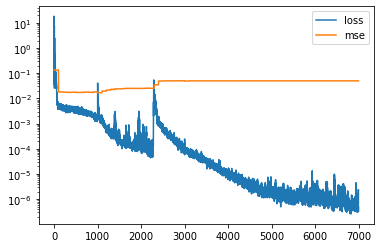

In [46]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

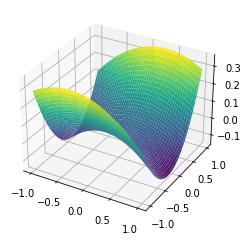

In [47]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');